In [1]:
%matplotlib inline

import matplotlib.pyplot as pyplot
import geopandas as gpd
import pandas as pd
import copy

from shapely.wkt import dumps
from shapely.wkt import loads

from weave_units import WeaveUnit

## Normalising tile units
Have to ensure TileUnits consist only of whole elements

<AxesSubplot:>

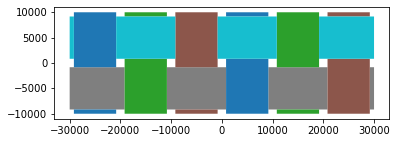

In [2]:
unit = WeaveUnit(aspect = 5/6, margin = 0.0, strands = "abc|de")
unit.elements.plot(column = "element_id")

Get width and height of the tile unit and hence translation vectors for copies.

In [3]:
bb = unit.tile.geometry[0].bounds
w = bb[2] - bb[0]
h = bb[3] - bb[1]
w, h
vectors = [(dx, dy) 
           for dx in (-w, 0, w) 
           for dy in (-h, 0, h) 
           if not (dx == 0 and dy == 0)]
# vectors.insert(0, (0, 0))

Make copies of the tile unit elements and tile, at the translation vector offsets, with the central tile labelled with tileID = 0.

In [4]:
all_elements = unit.elements.copy()
tile = unit.tile.copy()
tile["tileID"] = 0
all_tiles = copy.copy(tile)
for i, v in enumerate(vectors):
    these_elements = copy.copy(unit.elements)
    this_tile = copy.copy(tile)
    this_tile["tileID"] = i + 1
    these_elements.geometry = these_elements.geometry.translate(v[0], v[1])
    this_tile.geometry = this_tile.geometry.translate(v[0], v[1])
    all_elements = pd.concat([all_elements, these_elements])
    all_tiles = pd.concat([all_tiles, this_tile])


Dissolve on the element_id and explode to merge the elements. Note that we have to 'gridify' the coordinates to ensure thedissolve works correctly.

<AxesSubplot:>

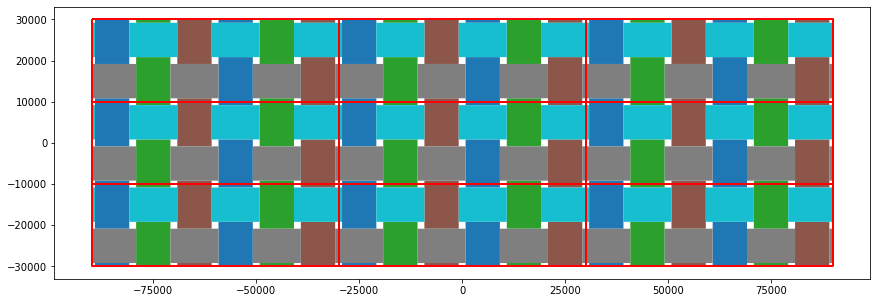

In [5]:

all_elements.geometry.apply(
    dumps, rounding_precision = 6).apply(loads)
all_elements = all_elements.dissolve(by = "element_id", as_index = False)
all_elements = all_elements.explode(ignore_index = True)

ax = all_elements.plot(column = "element_id", figsize = (50, 5))
all_tiles.plot(ax = ax, facecolor = "#00000000", 
           edgecolor = "r", linewidth = 2)

Finally, label the unique elements, then do an overlay between the tiles and the tile elements, and determine which is the largest overlapping part of each element in each tile. Make a lookup from this information join to the elements and then discard all elements not associated with tile 0.

<AxesSubplot:>

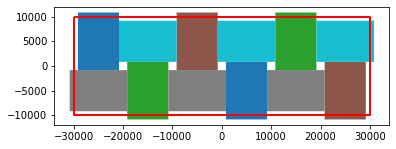

In [6]:
all_elements["UID"] = list(range(all_elements.shape[0]))

overlaps = all_elements.overlay(all_tiles)
overlaps["area"] = overlaps.geometry.area
lookup = overlaps.iloc[overlaps.groupby("UID")["area"].agg(
    pd.Series.idxmax)][["UID", "tileID"]]

all_elements = all_elements.merge(lookup, on = "UID")
all_elements = all_elements[all_elements.tileID == 0]

ax = all_elements.plot(column  = "element_id")
unit.tile.plot(ax = ax, facecolor = "#00000000", 
               edgecolor = "r", linewidth = 2)